In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import keras_spiking

tf.random.set_seed(0)
np.random.seed(0)

In [2]:
# Load MNIST Digits Dataset
((train_images, train_labels),(test_images, test_labels),) = tf.keras.datasets.mnist.load_data()

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

class_names = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9"
]

num_classes = len(class_names)
    
# repeat the images for n_steps
n_steps = 10
train_sequences = np.tile(train_images[:, None], (1, n_steps, 1, 1))
test_sequences = np.tile(test_images[:, None], (1, n_steps, 1, 1))

def train(input_model, train_x, test_x):
    input_model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    input_model.fit(train_x, train_labels, epochs=10)

    _, test_acc = input_model.evaluate(test_x, test_labels, verbose=2)


    print("\nTest accuracy:", test_acc)
    
def check_output(seq_model, modify_dt=None):
    """
    This code is only used for plotting purposes, and isn't necessary to
    understand the rest of this example; feel free to skip it
    if you just want to see the results.
    """

    # rebuild the model with the functional API, so that we can
    # access the output of intermediate layers
    inp = x = tf.keras.Input(batch_shape=seq_model.layers[0].input_shape)

    has_global_average_pooling = False
    for layer in seq_model.layers:
        if isinstance(layer, tf.keras.layers.GlobalAveragePooling1D):
            # remove the pooling so that we can see the model's
            # output over time
            has_global_average_pooling = True
            continue

        if isinstance(layer, (keras_spiking.SpikingActivation, keras_spiking.Lowpass)):
            cfg = layer.get_config()
            # update dt, if specified
            if modify_dt is not None:
                cfg["dt"] = modify_dt
            # always return the full time series so we can visualize it
            cfg["return_sequences"] = True

            layer = type(layer)(**cfg)

        if isinstance(layer, keras_spiking.SpikingActivation):
            # save this layer so we can access it later
            spike_layer = layer

        x = layer(x)

    func_model = tf.keras.Model(inp, [x, spike_layer.output])

    # copy weights to new model
    func_model.set_weights(seq_model.get_weights())

    # run model
    output, spikes = func_model.predict(test_sequences)

    if has_global_average_pooling:
        # check test accuracy using average output over all timesteps
        predictions = np.argmax(output.mean(axis=1), axis=-1)
    else:
        # check test accuracy using output from only the last timestep
        predictions = np.argmax(output[:, -1], axis=-1)
    accuracy = np.equal(predictions, test_labels).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    time = test_sequences.shape[1] * spike_layer.dt
    n_spikes = spikes * spike_layer.dt
    rates = np.sum(n_spikes, axis=1) / time

    print(
        "Spike rate per neuron (Hz): min=%.2f mean=%.2f max=%.2f"
        % (np.min(rates), np.mean(rates), np.max(rates))
    )

    # plot output
    for ii in range(4):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title(class_names[test_labels[ii]])
        plt.imshow(test_images[ii], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Spikes per neuron per timestep")
        bin_edges = np.arange(int(np.max(n_spikes[ii])) + 2) - 0.5
        plt.hist(np.ravel(n_spikes[ii]), bins=bin_edges)
        x_ticks = plt.xticks()[0]
        plt.xticks(
            x_ticks[(np.abs(x_ticks - np.round(x_ticks)) < 1e-8) & (x_ticks > -1e-8)]
        )
        plt.xlabel("# of spikes")
        plt.ylabel("Frequency")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(
            np.arange(test_sequences.shape[1]) * spike_layer.dt,
            tf.nn.softmax(output[ii]),
        )
        plt.legend(class_names, loc="upper left")
        plt.xlabel("Time (s)")
        plt.ylabel("Probability")
        plt.ylim([-0.05, 1.05])

        plt.tight_layout()
    return (100 * accuracy)

In [3]:
keras_spiking.default.dt = 0.01
time_step = 0.01

In [4]:
tau_acc_dict = dict()

No lowpass
Epoch 1/10
1875/1875 [==============================] - 30s 15ms/step - loss: 8.1519 - accuracy: 0.3258
Epoch 2/10
1875/1875 [==============================] - 32s 17ms/step - loss: 1.8107 - accuracy: 0.4736
Epoch 3/10
1875/1875 [==============================] - 34s 18ms/step - loss: 1.6802 - accuracy: 0.5493
Epoch 4/10
1875/1875 [==============================] - 29s 16ms/step - loss: 1.4938 - accuracy: 0.6358
Epoch 5/10
1875/1875 [==============================] - 27s 15ms/step - loss: 1.3973 - accuracy: 0.6827
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 1.3164 - accuracy: 0.71350s - loss: 1.3168 - ac
Epoch 7/10
1875/1875 [==============================] - 28s 15ms/step - loss: 1.2526 - accuracy: 0.7393
Epoch 8/10
1875/1875 [==============================] - 28s 15ms/step - loss: 1.2502 - accuracy: 0.7513
Epoch 9/10
1875/1875 [==============================] - 27s 14ms/step - loss: 1.2027 - accuracy: 0.7665
Epoch 10/10
1875/1875 [========

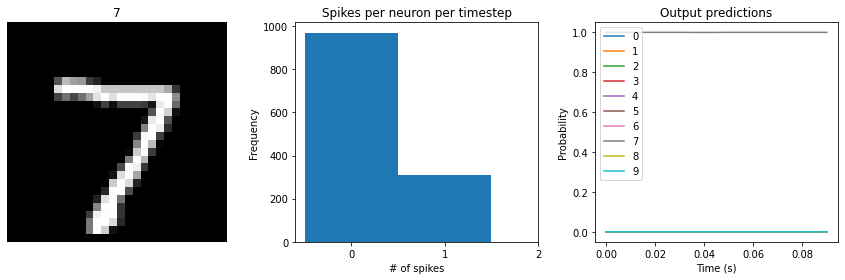

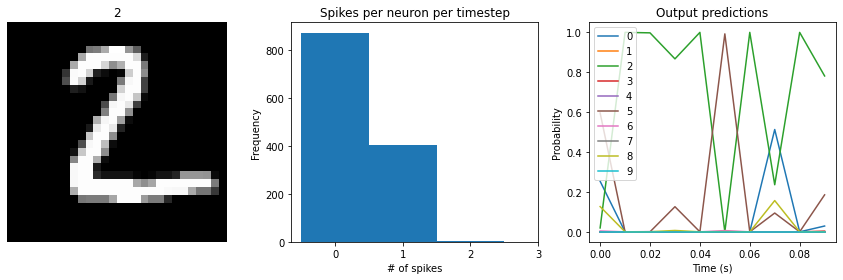

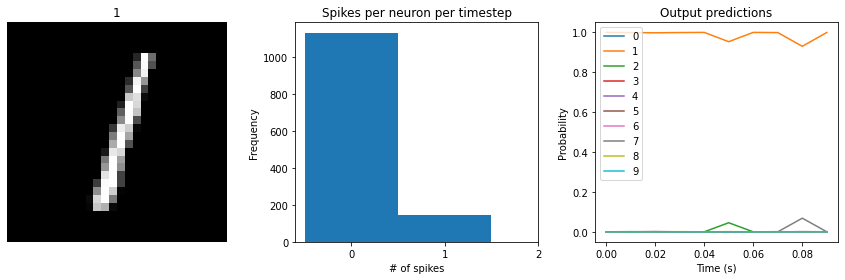

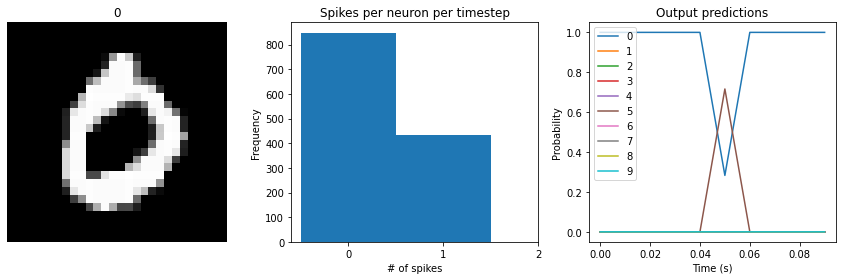

In [5]:
print("No lowpass")
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=True),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)

Tau: 0.005
Epoch 1/10
1875/1875 [==============================] - 55s 29ms/step - loss: 24.0698 - accuracy: 0.2317
Epoch 2/10
1875/1875 [==============================] - 53s 28ms/step - loss: 4.8665 - accuracy: 0.3494
Epoch 3/10
1875/1875 [==============================] - 52s 28ms/step - loss: 3.7658 - accuracy: 0.4528
Epoch 4/10
1875/1875 [==============================] - 60s 32ms/step - loss: 3.2762 - accuracy: 0.5471
Epoch 5/10
1875/1875 [==============================] - 53s 28ms/step - loss: 2.9379 - accuracy: 0.6128
Epoch 6/10
1875/1875 [==============================] - 53s 28ms/step - loss: 2.7856 - accuracy: 0.6557
Epoch 7/10
1875/1875 [==============================] - 55s 29ms/step - loss: 2.6034 - accuracy: 0.6936
Epoch 8/10
1875/1875 [==============================] - 54s 29ms/step - loss: 2.4839 - accuracy: 0.7112
Epoch 9/10
1875/1875 [==============================] - 57s 31ms/step - loss: 2.4142 - accuracy: 0.7282
Epoch 10/10
1875/1875 [=============================

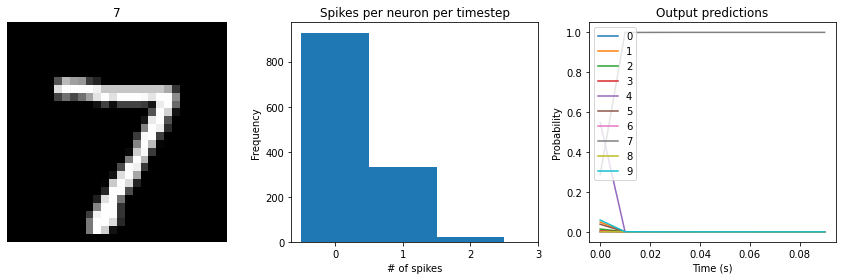

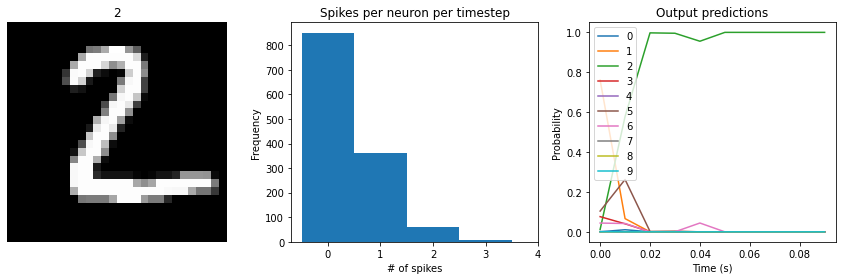

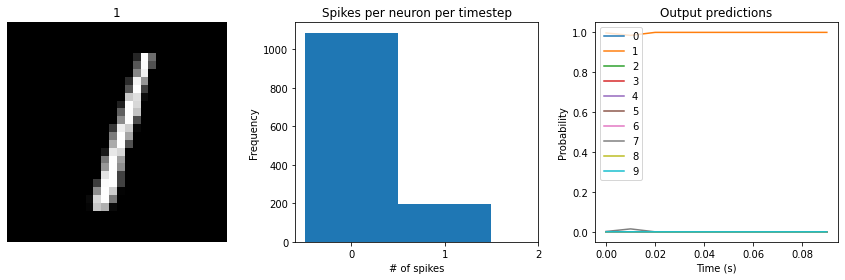

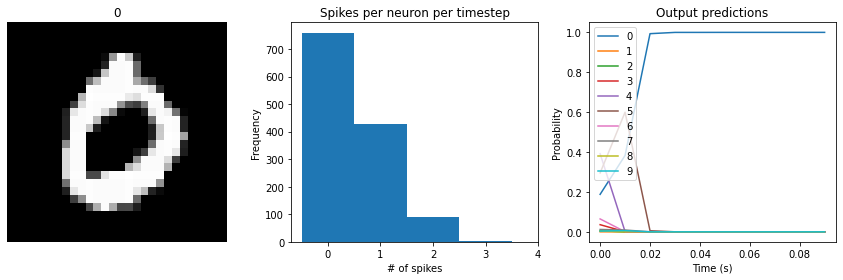

In [6]:
tau = 0.005
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=True),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

Tau: 0.01
Epoch 1/10
1875/1875 [==============================] - 51s 27ms/step - loss: 18.6259 - accuracy: 0.2860
Epoch 2/10
1875/1875 [==============================] - 52s 28ms/step - loss: 3.1670 - accuracy: 0.4290
Epoch 3/10
1875/1875 [==============================] - 52s 28ms/step - loss: 2.4313 - accuracy: 0.5071
Epoch 4/10
1875/1875 [==============================] - 52s 28ms/step - loss: 2.0917 - accuracy: 0.5960
Epoch 5/10
1875/1875 [==============================] - 53s 28ms/step - loss: 1.8076 - accuracy: 0.6565
Epoch 6/10
1875/1875 [==============================] - 53s 28ms/step - loss: 1.6265 - accuracy: 0.6989
Epoch 7/10
1875/1875 [==============================] - 50s 27ms/step - loss: 1.5336 - accuracy: 0.7293
Epoch 8/10
1875/1875 [==============================] - 52s 28ms/step - loss: 1.4245 - accuracy: 0.7473
Epoch 9/10
1875/1875 [==============================] - 51s 27ms/step - loss: 1.3476 - accuracy: 0.7654
Epoch 10/10
1875/1875 [==============================

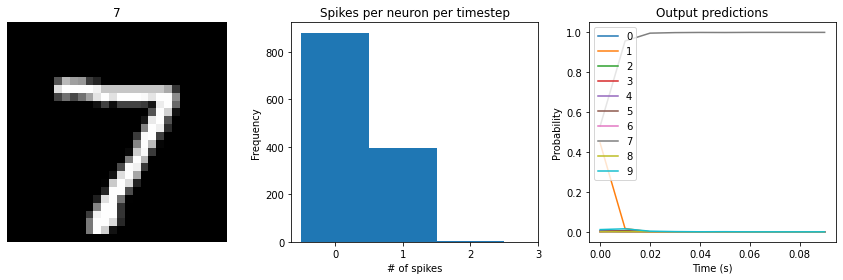

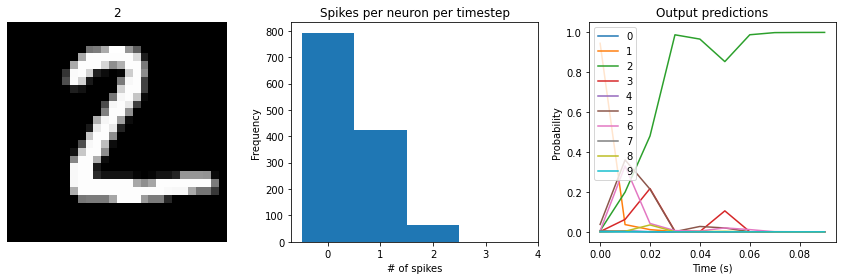

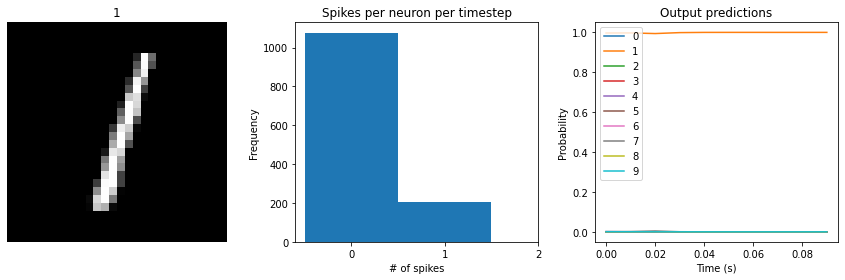

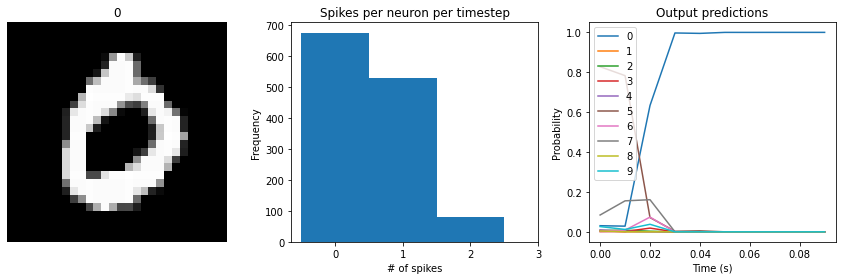

In [7]:
tau = 0.01
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=True),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

Tau: 0.05
Epoch 1/10
1875/1875 [==============================] - 55s 29ms/step - loss: 6.3997 - accuracy: 0.3256
Epoch 2/10
1875/1875 [==============================] - 55s 29ms/step - loss: 1.4309 - accuracy: 0.5169
Epoch 3/10
1875/1875 [==============================] - 52s 28ms/step - loss: 1.1569 - accuracy: 0.6144
Epoch 4/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.9433 - accuracy: 0.6874
Epoch 5/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.7819 - accuracy: 0.7446
Epoch 6/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.6761 - accuracy: 0.7829
Epoch 7/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.6016 - accuracy: 0.80800s - los
Epoch 8/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.5662 - accuracy: 0.82170s - l
Epoch 9/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.5210 - accuracy: 0.8355
Epoch 10/10
1875/1875 [=================

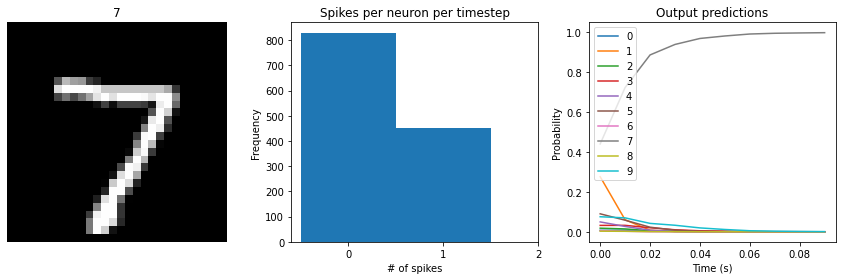

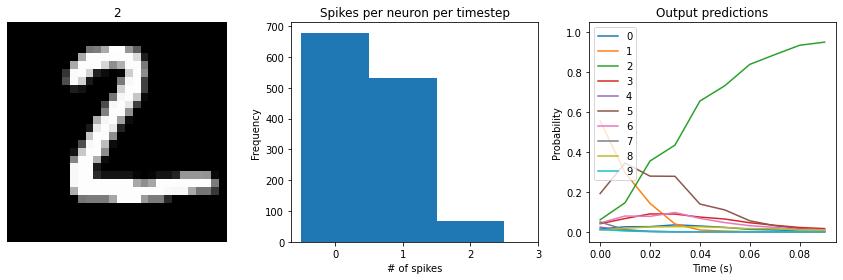

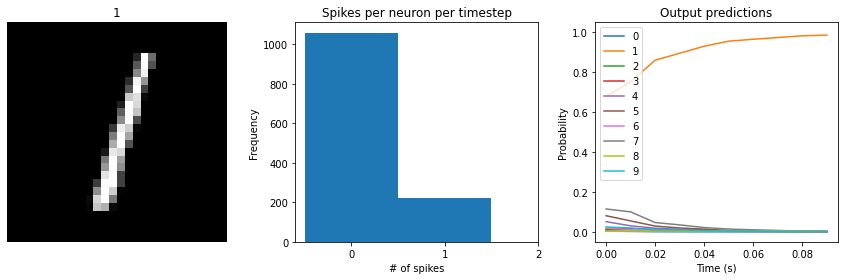

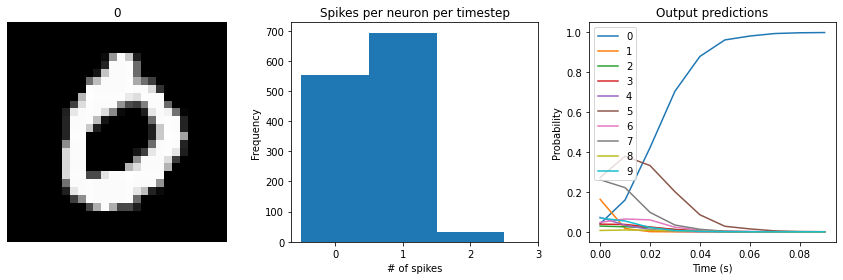

In [8]:
tau = 0.05
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=True),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

Tau: 0.1
Epoch 1/10
1875/1875 [==============================] - 53s 27ms/step - loss: 4.4413 - accuracy: 0.3295
Epoch 2/10
1875/1875 [==============================] - 51s 27ms/step - loss: 1.3189 - accuracy: 0.5502
Epoch 3/10
1875/1875 [==============================] - 55s 29ms/step - loss: 1.0801 - accuracy: 0.6413
Epoch 4/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.8470 - accuracy: 0.7185
Epoch 5/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.7154 - accuracy: 0.7668
Epoch 6/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.6382 - accuracy: 0.7948
Epoch 7/10
1875/1875 [==============================] - 50s 26ms/step - loss: 0.5742 - accuracy: 0.8188
Epoch 8/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.5466 - accuracy: 0.8298
Epoch 9/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.5005 - accuracy: 0.8418
Epoch 10/10
1875/1875 [==============================] 

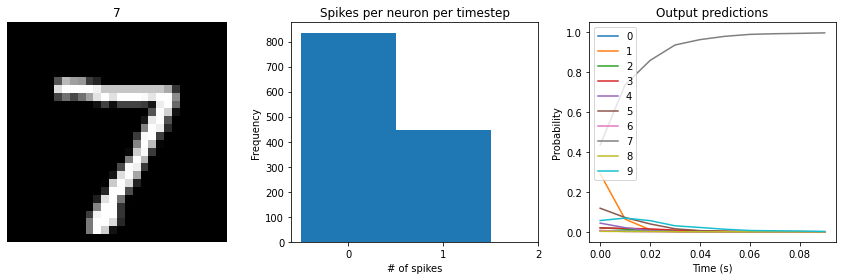

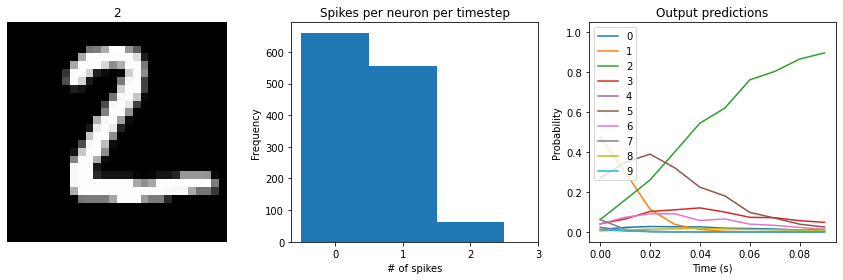

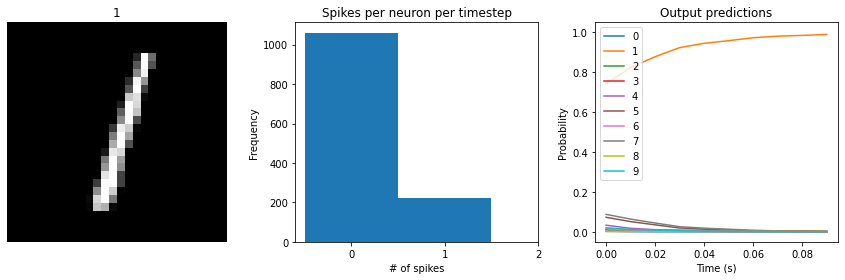

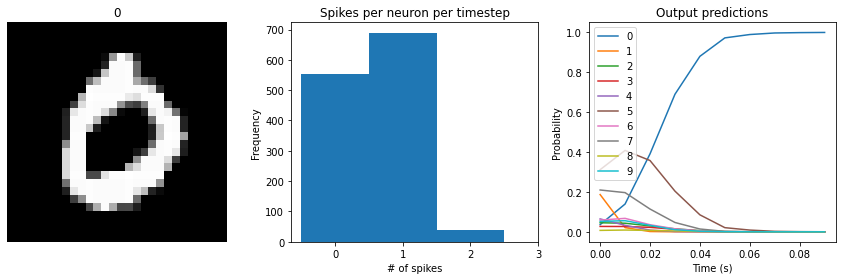

In [9]:
tau = 0.1
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=True),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

Tau: 0.5
Epoch 1/10
1875/1875 [==============================] - 51s 27ms/step - loss: 2.2927 - accuracy: 0.3629
Epoch 2/10
1875/1875 [==============================] - 48s 26ms/step - loss: 1.0714 - accuracy: 0.6334
Epoch 3/10
1875/1875 [==============================] - 48s 25ms/step - loss: 0.8457 - accuracy: 0.7193
Epoch 4/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.6996 - accuracy: 0.7738
Epoch 5/10
1875/1875 [==============================] - 50s 27ms/step - loss: 0.6068 - accuracy: 0.8045
Epoch 6/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.5653 - accuracy: 0.8214
Epoch 7/10
1875/1875 [==============================] - 50s 27ms/step - loss: 0.5189 - accuracy: 0.8379
Epoch 8/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.4976 - accuracy: 0.8457
Epoch 9/10
1875/1875 [==============================] - 48s 26ms/step - loss: 0.4611 - accuracy: 0.8572
Epoch 10/10
1875/1875 [==============================] 

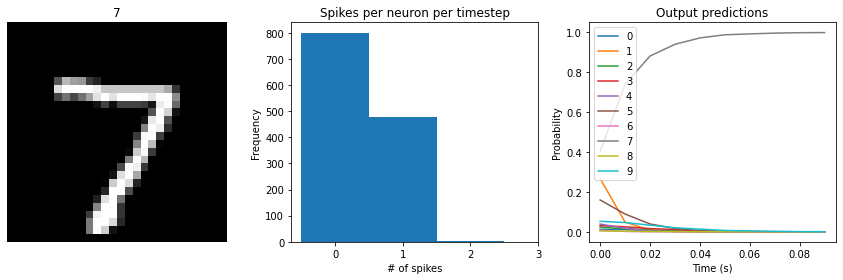

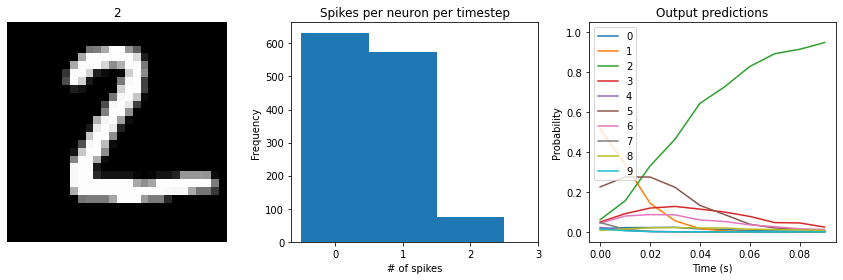

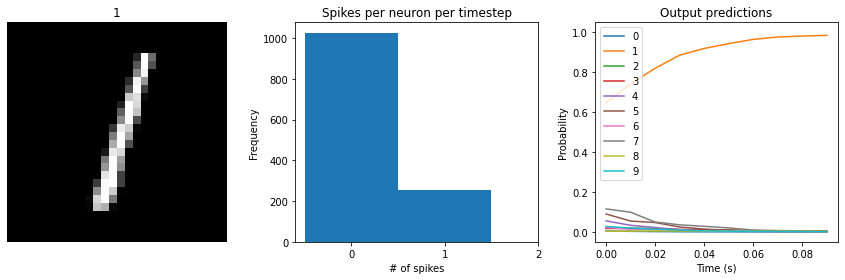

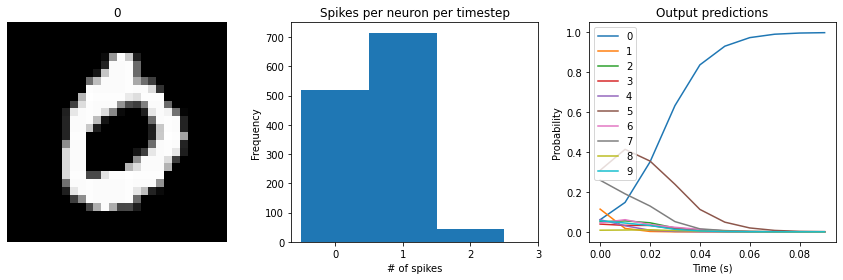

In [10]:
tau = 0.5
print("Tau:", tau)
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=True),
        keras_spiking.Lowpass(tau=tau, dt=time_step, return_sequences=False),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)
test_acc = check_output(spiking_model, modify_dt=time_step)
tau_acc_dict[tau] = test_acc

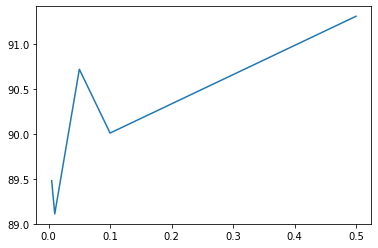

In [12]:
import matplotlib.pyplot as plt

tau_acc_list = tau_acc_dict.items()
tau_acc_list = sorted(tau_acc_list) 
x, y = zip(*tau_acc_list) 

plt.plot(x, y)
plt.xscale('log')
plt.xlabel('')
plt.show()